In [13]:
import random
from captcha.image import random_color,  ImageCaptcha
from PIL.Image import new as createImage, Image, Resampling
from PIL.ImageDraw import Draw, ImageDraw
from PIL.ImageFilter import SMOOTH, SMOOTH_MORE, SHARPEN, FIND_EDGES, EMBOSS, EDGE_ENHANCE, DETAIL, BLUR
from typing import Union, Tuple
import numpy as np
from PIL import Image as PILImage

ColorTuple = Union[Tuple[int, int, int], Tuple[int, int, int, int]]
Point = Tuple[int, int]


def quadratic_bezier_curve(start_point: Point, control_point: Point, end_point: Point, num=100):
    """
    计算二次贝塞尔曲线上的点
    """
    points = []
    for i in range(num + 1):
        t = i / num
        x = (1 - t)**2 * start_point[0] + 2 * (1 - t) * \
            t * control_point[0] + t**2 * end_point[0]
        y = (1 - t)**2 * start_point[1] + 2 * (1 - t) * \
            t * control_point[1] + t**2 * end_point[1]
        points.append((x, y))
    return points


def generate_black_white_noise(width, height, density=0.05, black_ration: float = 0.1):
    """
    生成黑白随机噪点数组。

    :param width: 噪点区域的宽度
    :param height: 噪点区域的高度
    :param density: 噪点密度（0到1之间的浮点数）
    :return: 一个 (height, width, 3) 的 NumPy 数组，包含黑白噪点
    """
    # 生成随机数矩阵
    random_matrix = np.random.rand(height, width)

    # 确定噪点位置
    noise_mask = random_matrix < density

    # 随机选择黑色或白色
    # 50% 选择黑色，50% 选择白色
    noise_colors = np.where(np.random.rand(
        height, width, 1) < black_ration, 0, 255).astype(np.uint8)

    return noise_mask, noise_colors


def add_black_white_noise_to_region(image: Image, region: Tuple[int, int, int, int], density=0.05, black_ration=0.1):
    """
    在给定图像的指定区域内添加黑白噪点，而不改变其他区域。

    :param image: Pillow Image 对象
    :param region: 噪点区域的边界框 (left, upper, right, lower)
    :param density: 噪点密度（0到1之间的浮点数）
    :return: 添加噪点后的 Pillow Image 对象
    """
    left, top, right, bottom = region
    width = right - left
    height = bottom - top

    # 转换图像为 NumPy 数组
    image_array = np.array(image)

    # 提取指定区域的像素
    region_array = image_array[top:bottom, left:right].copy()

    # 生成噪点掩码和噪点颜色
    noise_mask, noise_colors = generate_black_white_noise(
        width, height, density, black_ration)

    # 应用噪点：将噪点颜色覆盖到噪点掩码为 True 的位置
    region_array[noise_mask] = noise_colors[noise_mask]

    # 更新原图像的指定区域
    image_array[top:bottom, left:right] = region_array

    # 转换回 Pillow 图像
    noisy_image = PILImage.fromarray(image_array)

    return noisy_image


class NewImageCaptcha(ImageCaptcha):
    def __init__(self, width: int = 160, height: int = 60, fonts: list[str] | None = None, font_sizes: tuple[int, ...] | None = None):
        super().__init__(width, height, fonts, font_sizes)
        self.character_warp_dx = (0.01, 0.02)
        self.character_warp_dy = (0.01, 0.02)
        self.word_space_probability = 0
        self.word_offset_dx = 0.15
        self.character_rotate = (-10, 10)
        self.lookup_table: list[int] = [int(i * 10.97) for i in range(256)]

    def create_bezier_curve(self, image: Image, width: int = 2, number: int = 3):
        w, h = image.size
        while number:
            x1 = random.randint(0, w-20)
            y1 = random.randint(0, h-10)

            x2 = random.randint(x1, x1 + random.randint(20, w // 5))
            y2 = random.randint(y1, y1 + random.randint(20, h // 2))

            offset = 10
            control_x = random.randint(x1 - offset, x2 + offset)
            control_y = random.randint(y1 - offset, y2 + offset)
            curve_points = quadratic_bezier_curve(
                (x1, y1), (control_x, control_y), (x2, y2), num=100)
            color = random_color(0, 255)
            # 绘制曲线
            Draw(image).line(curve_points, fill=color, width=width)
            number -= 1
        return image

    def create_noise_curve(self, image: Image, color: ColorTuple, width: int = 2, number: int = 0) -> Image:
        w, h = image.size
        while number:
            x1 = random.randint(0, w-20)
            y1 = random.randint(0, h-10)

            x2 = random.randint(x1, x1 + random.randint(30, w // 2))
            y2 = random.randint(y1, y1 + random.randint(15, h))
            points = [x1, y1, x2, y2]
            start = random.randint(0, 20)
            end = random.randint(160, 200)
            Draw(image).arc(points, start, end, fill=color, width=width)
            number -= 1
        return image

    def create_noise_dots(self,
                          image: Image,
                          color: ColorTuple,
                          width: int = 3,
                          number: int = 30) -> Image:
        draw = Draw(image)
        w, h = image.size
        while number:
            x1 = random.randint(0, w)
            y1 = random.randint(0, h)
            draw.line(((x1, y1), (x1 - 1, y1 - 1)), fill=color, width=width)
            number -= 1
        return image

    def create_linear_gradient(self, width, height, start_color, end_color, angle):
        """
        创建具有任意角度的线性渐变背景

        :param width: 图像宽度
        :param height: 图像高度
        :param start_color: 起始颜色，(R, G, B) 元组，值范围 0-255
        :param end_color: 结束颜色，(R, G, B) 元组，值范围 0-255
        :param angle: 渐变角度，以度为单位，0 度表示从左到右，顺时针方向
        :return: Pillow 图像对象
        """
        # 将角度转换为弧度
        angle_rad = np.deg2rad(angle % 360)

        # 创建坐标网格
        x = np.linspace(0, 1, width)
        y = np.linspace(0, 1, height)
        x_grid, y_grid = np.meshgrid(x, y)

        # 计算投影
        # 调整坐标系，使原点在图像中心
        x_grid -= 0.5
        y_grid -= 0.5

        # 计算在渐变方向上的投影
        # 渐变方向的单位向量
        gradient_vector = np.array([np.cos(angle_rad), np.sin(angle_rad)])
        # 将坐标点展平成二维数组
        coords = np.stack((x_grid.ravel(), y_grid.ravel()), axis=1)
        # 计算每个点在渐变方向上的投影
        projections = np.dot(coords, gradient_vector)
        # 将投影值归一化到 [0, 1]
        projections = (projections - projections.min()) / \
            (projections.max() - projections.min())
        projections = projections.reshape((height, width))

        # 计算渐变颜色
        start_color = np.array(start_color).reshape(1, 1, 3)
        end_color = np.array(end_color).reshape(1, 1, 3)
        gradient = start_color + (end_color - start_color) * \
            projections[:, :, np.newaxis]

        # 确保颜色值在正确范围内
        gradient = np.clip(gradient, 0, 255).astype(np.uint8)

        # 将 NumPy 数组转换为 Pillow 图像
        image = PILImage.fromarray(gradient)

        return image

    def create_black_white_noise(self, image: Image, density: float, black_ration: float) -> Image:
        width, height = image.size
        left = 0
        top = random.randint(0, height - 10)  # 顶部起始位置
        right = width
        bottom = min(random.randint(
            top, top + (height // 2)), height)  # 底部结束位置

        region = (
            left, top, right, bottom
        )

        return add_black_white_noise_to_region(image, region, density, black_ration)

    def _draw_character(
            self,
            c: str,
            draw: ImageDraw,
            color: ColorTuple) -> Image:
        font = random.choice(self.truefonts)
        _, _, w, h = draw.multiline_textbbox((1, 1), c, font=font)

        dx1 = random.randint(*self.character_offset_dx)
        dy1 = random.randint(*self.character_offset_dy)
        im = createImage('RGBA', (w + dx1, h + dy1))
        Draw(im).text((dx1, dy1), c, font=font, fill=color)

        # rotate
        im = im.crop(im.getbbox())
        im = im.rotate(
            random.uniform(*self.character_rotate),
            Resampling.BILINEAR,
            expand=True,
        )

        # warp
        dx2 = w * random.uniform(*self.character_warp_dx)
        dy2 = h * random.uniform(*self.character_warp_dy)
        x1 = int(random.uniform(-dx2, dx2))
        y1 = int(random.uniform(-dy2, dy2))
        x2 = int(random.uniform(-dx2, dx2))
        y2 = int(random.uniform(-dy2, dy2))
        w2 = w + abs(x1) + abs(x2)
        h2 = h + abs(y1) + abs(y2)
        data = (
            x1, y1,
            -x1, h2 - y2,
            w2 + x2, h2 + y2,
            w2 - x2, -y1,
        )
        # im = im.resize((w2, h2))
        # im = im.transform((w, h), QUAD, data)
        return im

    def create_captcha_image(self, image: Image, chars: str) -> Image:
        """Create the CAPTCHA image itself.

        :param chars: text to be generated.
        :param color: color of the text.
        :param background: color of the background.

        The color should be a tuple of 3 numbers, such as (0, 255, 255).
        """
        draw = Draw(image)

        images: list[Image] = []
        for c in chars:
            if random.random() > self.word_space_probability:
                images.append(self._draw_character(" ", draw, (0, 0, 0)))
            color = random_color(10, 255, random.randint(150, 250))
            images.append(self._draw_character(c, draw, color))

        text_width = sum([im.size[0] for im in images])

        # 宽度扩展
        width = max(text_width, self._width)
        image = image.resize((width, self._height))

        # 每个有效字符占据的宽度
        average = int(text_width / len(chars))
        rand = int(self.word_offset_dx * average)
        offset = int(average * 0.1)

        for im in images:
            w, h = im.size
            mask = im.convert('L').point(self.lookup_table)
            # 放置字符
            y = random.randint(5, self._height - h - 5)
            image.paste(im, (offset, y), mask)
            # 下一个字符的起始 x 坐标
            offset = offset + w + random.randint(-rand, 0)

        # 恢复原始大小
        if width > self._width:
            image = image.resize((self._width, self._height))

        return image

    def genera_background(self):
        # 默认值 random_color(238, 255, 1)
        background_start_color = random_color(150, 255)
        background_end_color = random_color(150, 255)
        background_gradient_angle = random.randint(0, 180)
        # image = createImage('RGB', (self._width, self._height), background)
        image = self.create_linear_gradient(
            self._width, self._height, background_start_color, background_end_color, background_gradient_angle)
        return image

    def generate_image(self, chars: str, noise_ration=0.5):
        """Generate the image of the given characters.

        :param chars: text to be generated.
        """
        im = self.genera_background()
        if random.random() < noise_ration:
            im = self.create_bezier_curve(
                im, width=3, number=random.randint(0, 2))
        im = self.create_captcha_image(im, chars)
        if random.random() < noise_ration:
            im = self.create_noise_dots(
                im, random_color(0, 255), width=5, number=random.randint(0, 5))
        # im = self.create_noise_curve(im, random_color(
        #     0, 255),  width=3, number=random.randint(1, 1))
        if random.random() < (noise_ration / 2):
            im = self.create_black_white_noise(im, 0.1, 0.2)
        im = im.filter(SMOOTH)
        return im

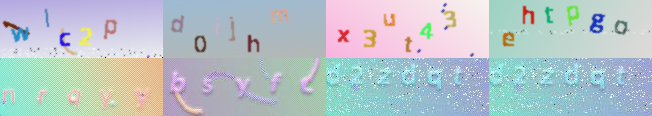

In [14]:
"""
评估生成的图片和真实图片的相似度
"""

from __future__ import annotations
import os
import random
from PIL.Image import new as createImage
from IPython.display import display
from PIL.Image import open  # type: ignore


def generate_captcha(count, width=163, height=58):
    img_list = []
    # 生成验证码图片
    captcha = NewImageCaptcha(width=width, height=height,
                              fonts=[
                                  '../fonts/Open_Sans/static/OpenSans-Light.ttf'],
                              font_sizes=(22, 24))

    for i in range(count):
        # k 表示验证码位数
        chars = ''.join(map(str, random.choices(
            '0123456789abcdefghijklmnopqrstuvwxyz', k=random.choice(range(4, 7)))))
        img = captcha.generate_image(chars)
        img_list.append(img)
    return img_list


def get_img_path_list(img_dir, limit):
    img_path_list = []
    for root, dirs, files in os.walk(img_dir):
        for file in files:
            file_extension = os.path.splitext(file)[1]
            if file_extension in ['.jpg', '.jpeg', '.png']:
                img_path_list.append(os.path.join(root, file))

    return random.choices(img_path_list, k=limit)


def read_img(img_path):
    img = open(img_path)
    return img


count = 4
real_img_path_list = get_img_path_list(
    '../data/train-3363-stable-new/test', count)

generate_img_list = generate_captcha(count)
real_img_list = [
    read_img(img_path) for img_path in real_img_path_list
]

width, height = generate_img_list[0].size
# 生成图片
generate_img = createImage('RGB', (width * count, height * 2))
for i in range(count):
    generate_img.paste(generate_img_list[i], (width * i, 0))
    generate_img.paste(real_img_list[i], (width * i, height))

# generate_img.show()
display(generate_img)